# Simulation-based inference (SBI) notebook



Neural infrence framework for infer interstellar gas temperature in galaxies across 4 dimensions (velocity and spatial dimensions)

In this notebook:
A neural infrence framework for infer interstellar gas temperature along velocity dimension


# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML/sbi
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML/sbi


# Install packages

In [ ]:
!pip install sbi --quiet

# Libraries

In [ ]:

import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import scipy as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


from sbi import utils
from sbi import analysis
from sbi.inference import SNPE #, simulate_for_sbi, prepare_for_sbi
from sbi.neural_nets import posterior_nn

from sklearn.decomposition import PCA

from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs         import WCS

import h5py
import pickle

from pathlib import Path

# set seed for numpy and torch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


%matplotlib inline

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

sbi_path         = base_path / 'sbi'
checkpoint_path  = sbi_path / 'checkpoints'

data_path       = base_path / 'data'
uma_data_path   = data_path / 'UMA'
seta_data_path  = data_path / 'seta'
saury_data_path = data_path / 'saury'

# Brightness Tb summary statistics with a neural network
This is a simulation-based inference of interstellar gas temperature along velocity axis. The simulator model generates emission Tb (v) spectra (256 channels) and I use a convolutional neural network as summary statistics extractor.

---

`sbi` offers functionality to learn summary statistics from (potentially high-dimensional) simulation outputs with a neural network. In `sbi`, this neural network is referred to as `embedding_net`. If an `embedding_net` is specified, the simulation outputs are passed through the `embedding_net`, whose outputs are then passed to the neural density estimator. The parameters of the `embedding_net` are learned together with the parameters of the neural density estimator.

# Read training dataset

In [ ]:
# Parameters
# Train on 1 million spectra
n_train = 1_046_576

# Test on 2000 spectra
n_test = 2000

spectrum_length = 256
vector_length = 64

In [ ]:
# Const
m_h = 1.6737236e-27
nz  = 1024
dz  = 200./nz # in pc
L = np.arange(0., nz, 1) * dz # in pc


#Velocity range and channel spacing
vmin = -40. # in km/s
vmax = 40.  # in km/s
dv   = 0.3125 # in km.s-1
v    = np.arange(vmin, vmax, dv) # Velocity axis in km/s

print(len(v))

256


In [ ]:
# Compute the factor by which to reduce the number of channels
factor = nz // vector_length

# Average channels
L128 = L.reshape(vector_length, factor).mean(axis=1)
L128.shape

(64,)

## Emission data cube

In [ ]:
data_file = saury_data_path / 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0.fits'
cube, hdr = fits.getdata(data_file, header=True)
cube = cube[:256, :, :]
print(cube.shape)

(256, 512, 512)


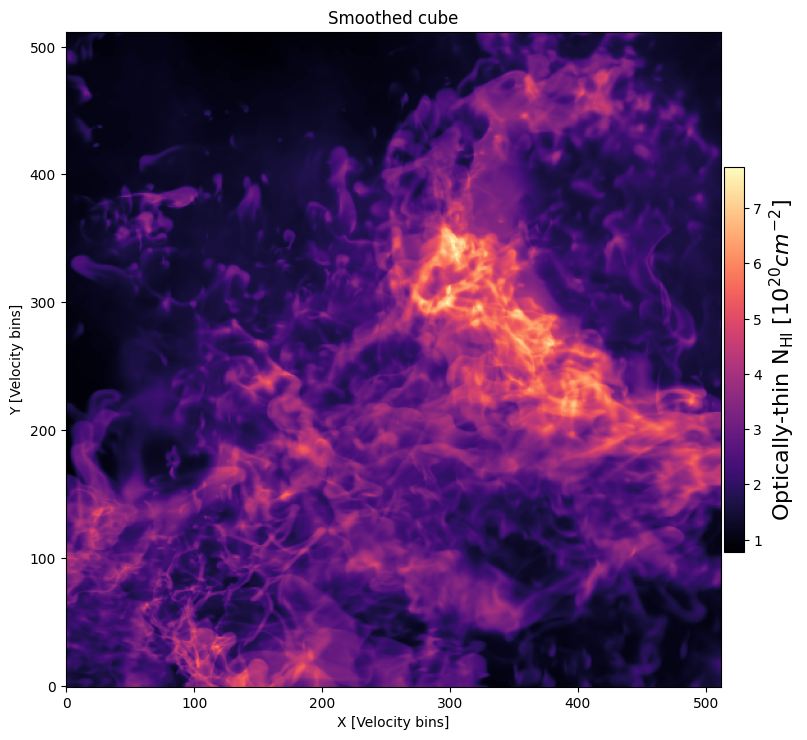

In [ ]:
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('Smoothed cube')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

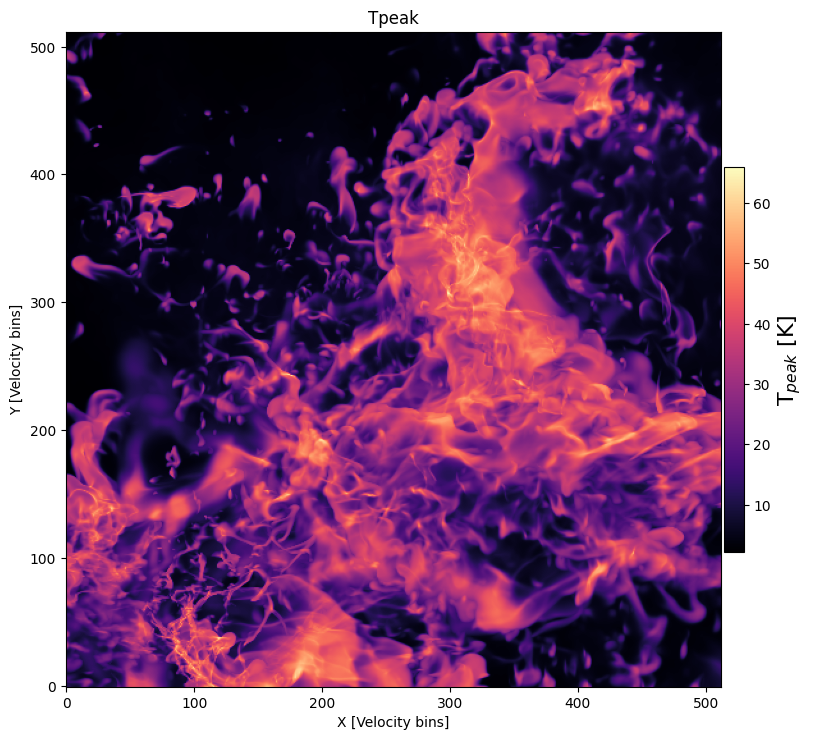

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(cube, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_{peak}$ [K]', size=16)

plt.title('Tpeak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Absorption data cube

In [ ]:
tau_data_file = saury_data_path / 'tau_n01_pw02_vs12_512_thick_256chan_quarter_0.fits'
tau_cube, hdr = fits.getdata(tau_data_file, header=True)
tau_cube = tau_cube[:256, :, :]

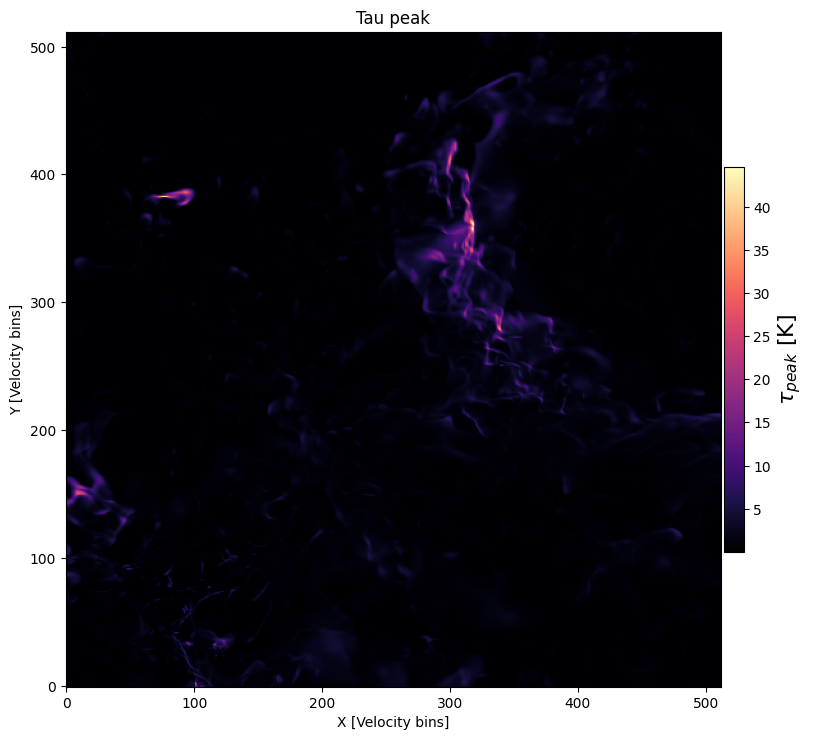

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(tau_cube, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$\tau_{peak}$ [K]', size=16)

plt.title('Tau peak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Gas temperature profiles: Tspin spectra

In [ ]:
ts_cube = cube / (1. - np.exp(-tau_cube))

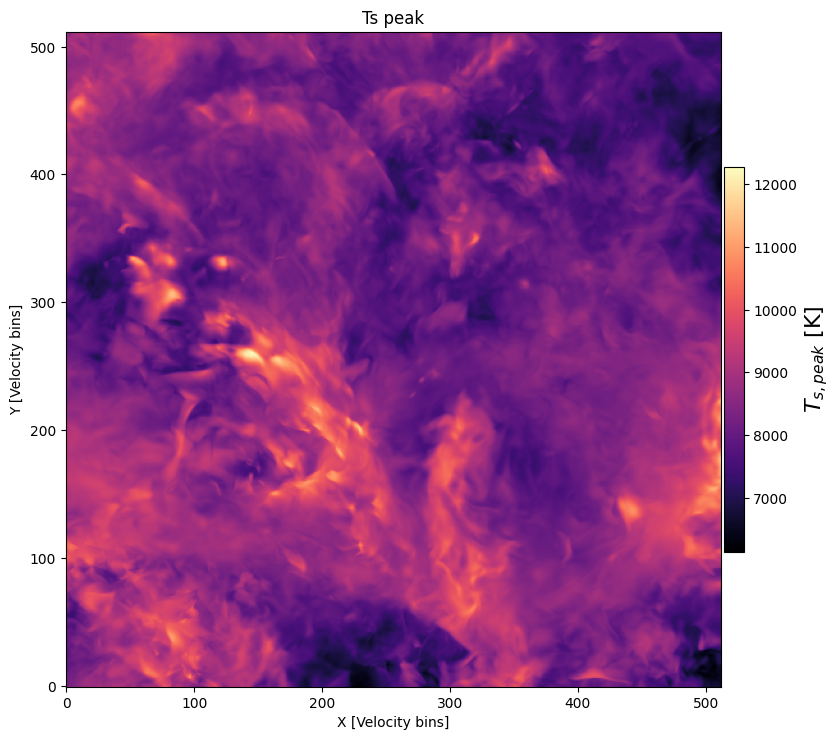

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(ts_cube, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$T_{s,peak}$ [K]', size=16)

plt.title('Ts peak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

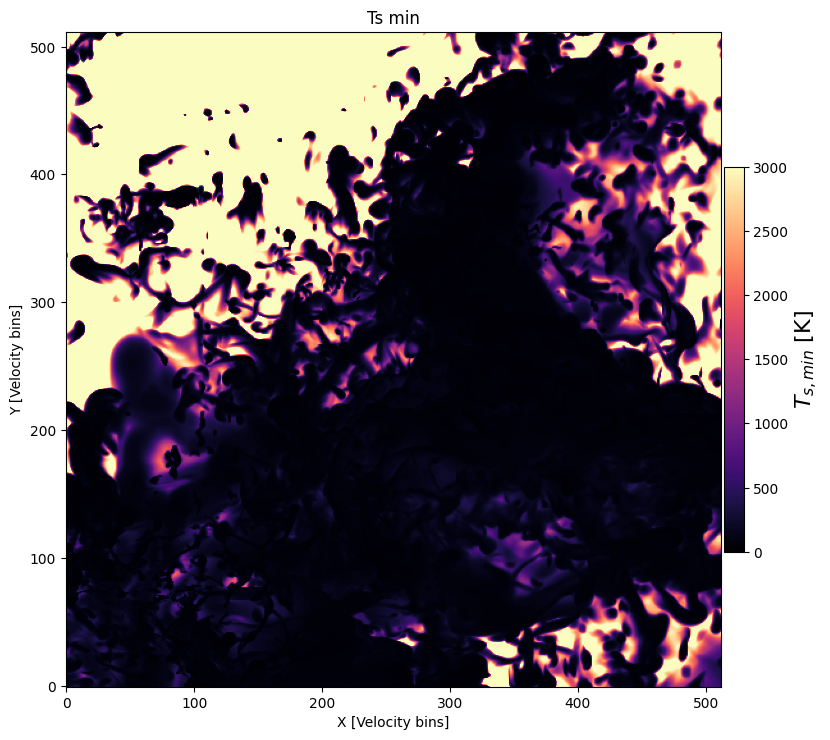

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.min(ts_cube, axis=0), cmap='magma', origin='lower', vmin=0., vmax=3000.)

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$T_{s,min}$ [K]', size=16)

plt.title('Ts min')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Reshape the data cubes

In [ ]:
# Here I show the process of 1 data cube only

nchan, ny, nx = cube.shape
nspec = nx * ny

# cube_rs = cube.reshape(-1, nchan, order='C')
cube_rs = cube.reshape(nchan, ny * nx).T
tau_cube_rs = tau_cube.reshape(nchan, ny * nx).T
ts_cube_rs = ts_cube.reshape(nchan, ny * nx).T

## Plot some spectra

In [ ]:
cube_rs.shape

(262144, 256)

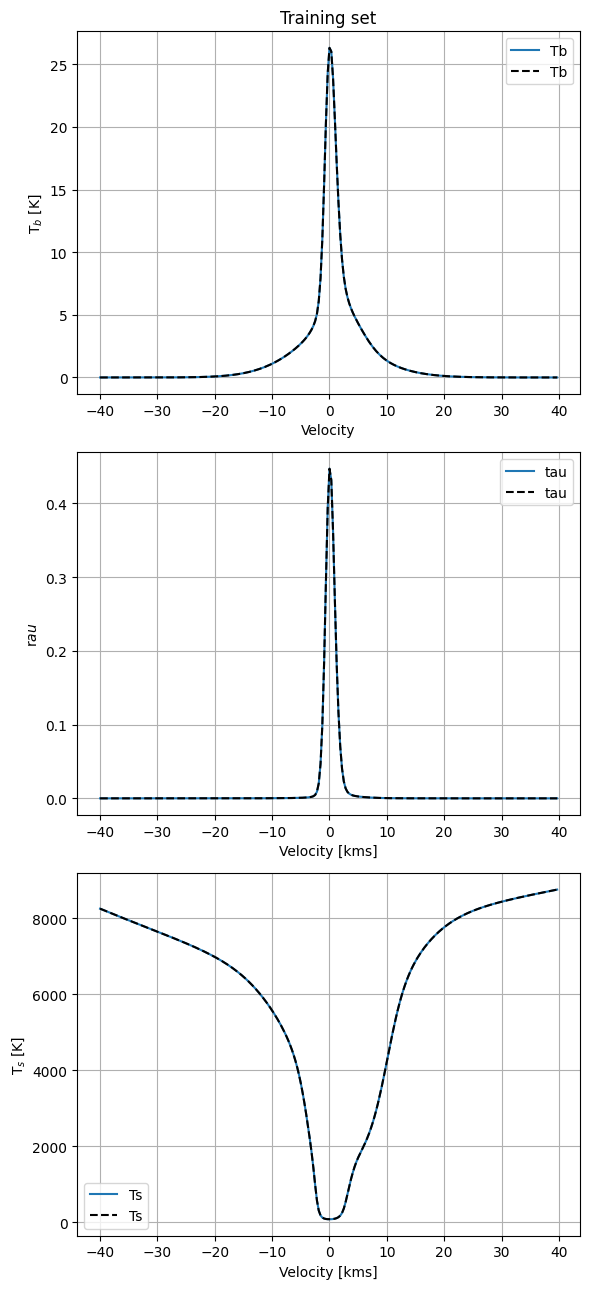

In [ ]:
i = 200
j = 100

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, cube[:, j, i], label='Tb')
ax1.plot(v, cube_rs[indx, :], 'k--', label='Tb')

ax1.set_title('Training set')
ax1.set_xlabel('Velocity')
ax1.set_ylabel('T$_b$ [K]')
ax1.grid()
ax1.legend()



#
ax2 = axs[1]
ax2.plot(v, tau_cube[:, j, i], label='tau')
ax2.plot(v, tau_cube_rs[indx, :], 'k--', label='tau')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [kms]')
ax2.set_ylabel('r$\tau$')
ax2.grid()
ax2.legend()



#
ax3 = axs[2]
ax3.plot(v, ts_cube[:, j, i], label='Ts')
ax3.plot(v, ts_cube_rs[indx, :], 'k--', label='Ts')

# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [kms]')
ax3.set_ylabel('T$_s$ [K]')
ax3.grid()
ax3.legend()



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

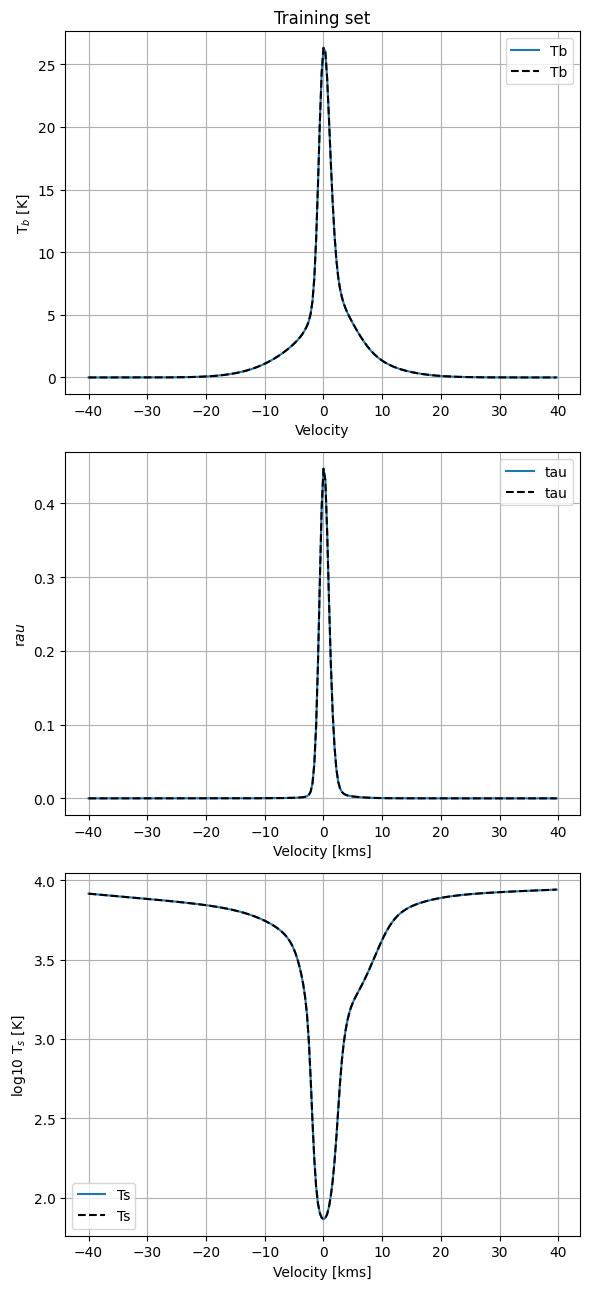

In [ ]:
i = 200
j = 100

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, cube[:, j, i], label='Tb')
ax1.plot(v, cube_rs[indx, :], 'k--', label='Tb')

ax1.set_title('Training set')
ax1.set_xlabel('Velocity')
ax1.set_ylabel('T$_b$ [K]')
ax1.grid()
ax1.legend()



#
ax2 = axs[1]
ax2.plot(v, tau_cube[:, j, i], label='tau')
ax2.plot(v, tau_cube_rs[indx, :], 'k--', label='tau')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [kms]')
ax2.set_ylabel('r$\tau$')
ax2.grid()
ax2.legend()



#
ax3 = axs[2]
ax3.plot(v, np.log10(ts_cube[:, j, i]), label='Ts')
ax3.plot(v, np.log10(ts_cube_rs[indx, :]), 'k--', label='Ts')

# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [kms]')
ax3.set_ylabel('log10 T$_s$ [K]')
ax3.grid()
ax3.legend()



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Emission data cube 1

In [ ]:
data_file1 = saury_data_path / 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1.fits'
cube1, hdr1 = fits.getdata(data_file1, header=True)
cube1 = cube1[:256, :, :]

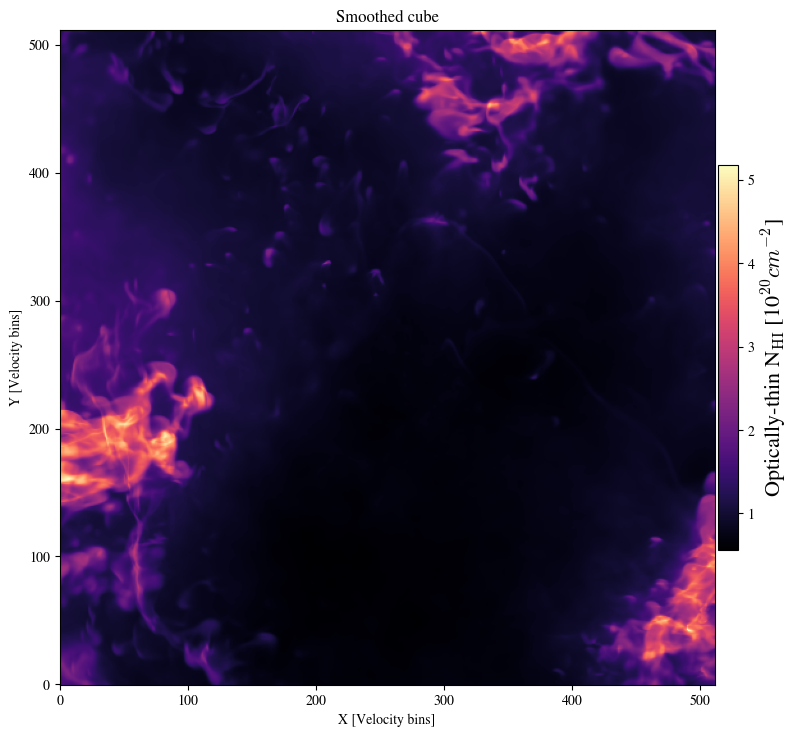

In [ ]:
WHI1 = np.sum(cube1, axis=0)
NHI1_thin = 1.8224 * 1.e-2 * WHI1 * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI1_thin, cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('Smoothed cube')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Absorption data cube 1

In [ ]:
tau_data_file1 = saury_data_path / 'tau_n01_pw02_vs12_512_thick_256chan_quarter_1.fits'
tau_cube1, hdr1 = fits.getdata(tau_data_file1, header=True)
tau_cube1 = tau_cube1[:256, :, :]

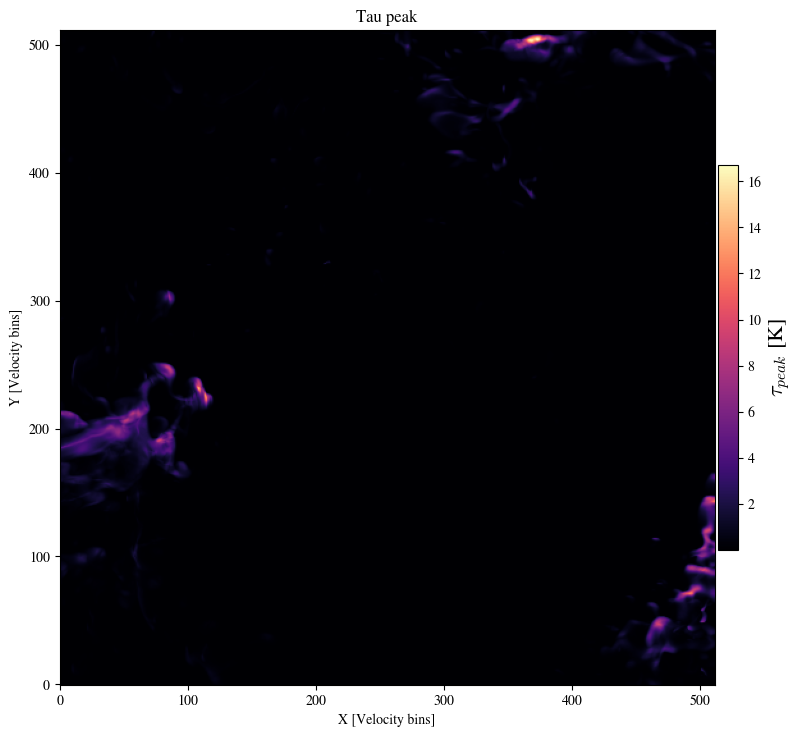

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(tau_cube1, axis=0), cmap='magma', origin='lower') #, vmin=0., vmax=3.)

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$\tau_{peak}$ [K]', size=16)

plt.title('Tau peak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Gas temperature profile: Tspin spectra

In [ ]:
ts_cube1 = cube1 / (1. - np.exp(-tau_cube1))

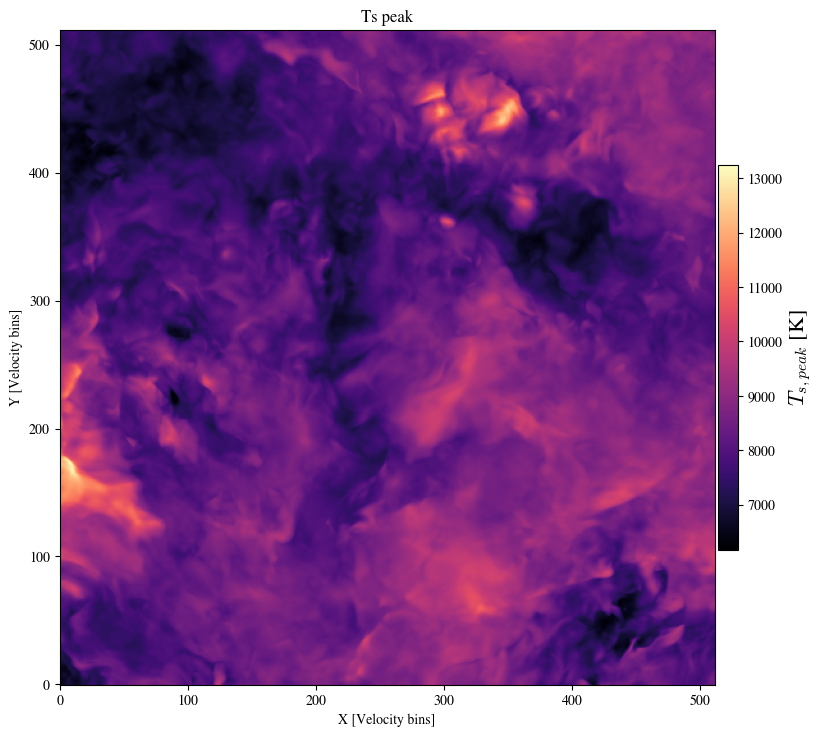

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(ts_cube1, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$T_{s,peak}$ [K]', size=16)

plt.title('Ts peak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

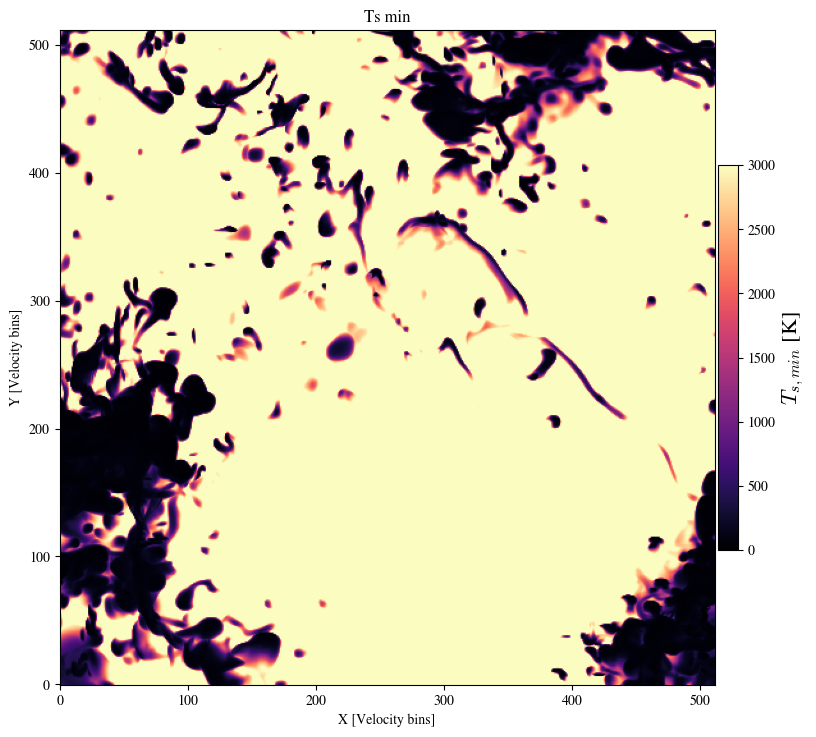

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.min(ts_cube1, axis=0), cmap='magma', origin='lower', vmin=0., vmax=3000.)

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$T_{s,min}$ [K]', size=16)

plt.title('Ts min')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

In [ ]:
# Here I show the process of 1 data cube only

nchan1, ny1, nx1 = cube1.shape
nspec1 = nx1 * ny1

# cube_rs = cube.reshape(-1, nchan, order='C')
cube1_rs = cube1.reshape(nchan1, ny1 * nx1).T
tau_cube1_rs = tau_cube1.reshape(nchan1, ny1 * nx1).T
ts_cube1_rs = ts_cube1.reshape(nchan1, ny1 * nx1).T

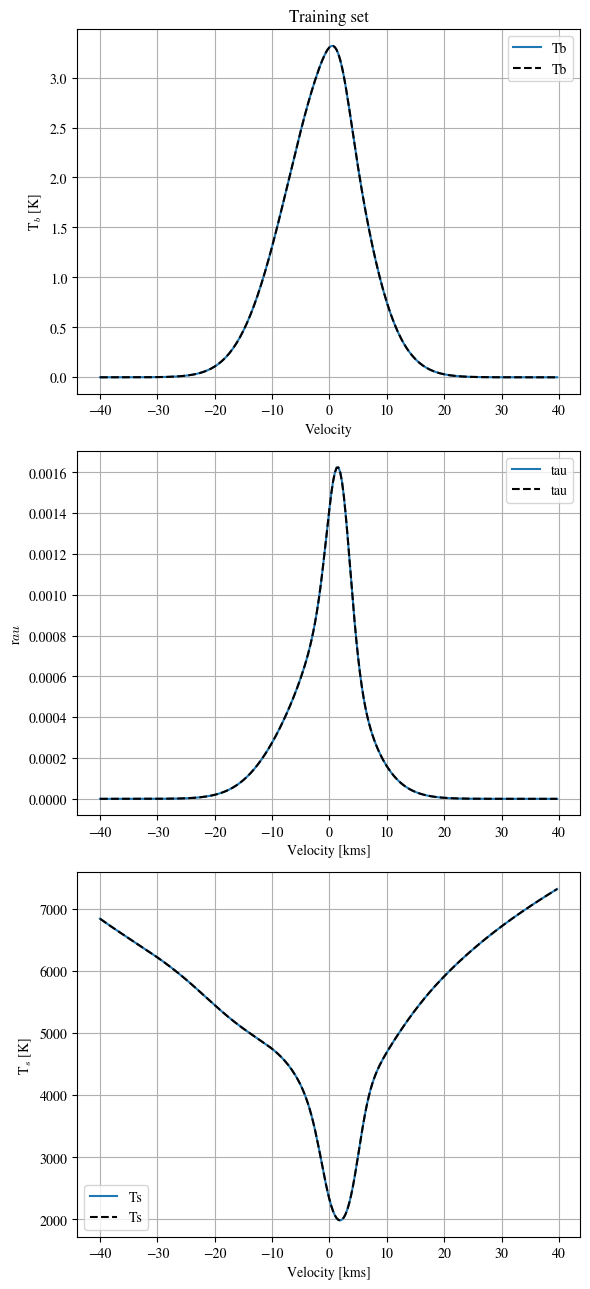

In [ ]:
i = 200
j = 300

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, cube1[:, j, i], label='Tb')
ax1.plot(v, cube1_rs[indx, :], 'k--', label='Tb')

ax1.set_title('Training set')
ax1.set_xlabel('Velocity')
ax1.set_ylabel('T$_b$ [K]')
ax1.grid()
ax1.legend()



#
ax2 = axs[1]
ax2.plot(v, tau_cube1[:, j, i], label='tau')
ax2.plot(v, tau_cube1_rs[indx, :], 'k--', label='tau')

ax2.set_xlabel('Velocity [kms]')
ax2.set_ylabel('r$\tau$')
ax2.grid()
ax2.legend()



#
ax3 = axs[2]
ax3.plot(v, ts_cube1[:, j, i], label='Ts')
ax3.plot(v, ts_cube1_rs[indx, :], 'k--', label='Ts')

ax3.set_xlabel('Velocity [kms]')
ax3.set_ylabel('T$_s$ [K]')
ax3.grid()
ax3.legend()



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Temperature of all data cubes: convert to log10

In [ ]:
ts_cube1_rs = np.log10(ts_cube1_rs)
ts_cube2_rs = np.log10(ts_cube2_rs)

ts_cube3_rs = np.log10(ts_cube3_rs)
ts_cube4_rs = np.log10(ts_cube4_rs)

# Combine all data cubes: more than 1 million spectra
ts_cube_rs = np.concatenate([ts_cube1_rs,
                             ts_cube2_rs,
                             ts_cube3_rs,
                             ts_cube4_rs],
                            axis=0)

# Preprocess

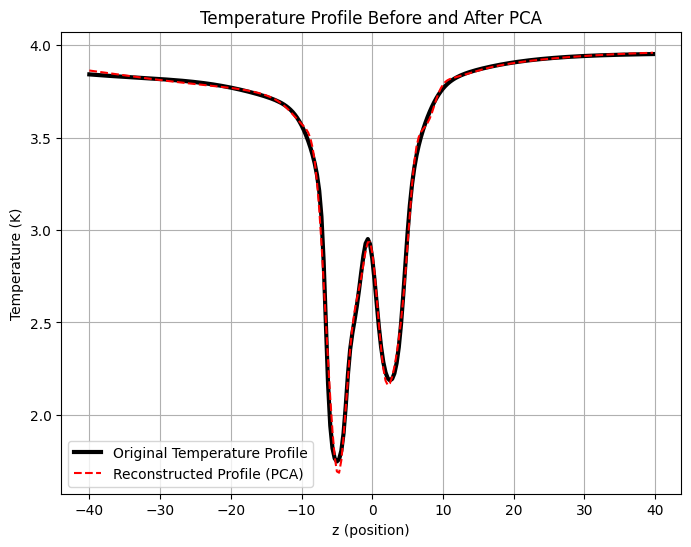

In [ ]:
i = 123
j = 111

plt.figure(figsize=(8, 6))
plt.plot(v, ts_cube_rs[j*512+i, :], lw=3, label='Original Temperature Profile', color='k')
plt.plot(v, temp_rs_reconstructed[j*512+i, :], ls='--', label='Reconstructed Profile (PCA)', color='r')
plt.xlabel('z (position)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Temperature Profile Before and After PCA')
plt.grid(True)
plt.show()

# Defining an `embedding_net`

SBI will apply an inference procedure to the output from the simulator model to determine the posterior distribution of $\theta_E$ given an observation of $x$ (the tb spectrum). Unfortunately, at present, the output data lives in a 256 dimensional space (256 channels). To avoid working directly with $x$ (because high-dimensional images are very computationally expensive), we will use a convolutional neural network (CNN) that takes the 256-channel spectra as input and encodes them into 64-dimensional feature vectors. This embedding net allows us to change the output dimension of the data $x$ from 256 to 64.

We define and instantiate the CNN as follows:

In [ ]:
class SummaryNet(nn.Module):

    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        # Maxpool layer that reduces 256 image to ??
        self.pool = nn.MaxPool1d(kernel_size=8, stride=8)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=8*8*8, out_features=64)

    def forward(self, x):
        x = x.view(-1, 1, 256)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8*8*8)
        x = F.relu(self.fc(x))
        return x



embedding_net = SummaryNet()

# print a summary of the embedding net
summary(embedding_net, (1, 1, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 256]              96
         MaxPool1d-2               [-1, 16, 32]               0
            Linear-3                   [-1, 64]          32,832
Total params: 32,928
Trainable params: 32,928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.13
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


# The inference procedure

With the `embedding_net` defined and instantiated, we can follow the usual workflow of an inference procedure in `sbi`. The `embedding_net` object appears as an input argument when instantiating the neural density estimator with `utils.posterior_nn`.

Simulation based inference is a technique to perform maximum likelihood and Bayesian estimation without needing a likelihood function.

In [ ]:
print('Device:', device)

Device: cpu


In [ ]:
n_comps = 128

# set prior distribution for the Tspin temperature
prior_low = -8.
prior_high = 8.
num_dim = 1

# Assume a uniform prior for simplicity
params_length = 1*n_comps
prior = utils.BoxUniform(low=prior_low*torch.ones(params_length), high=prior_high*torch.ones(params_length), device=device)

In [ ]:
samp = prior.sample()
samp.shape

torch.Size([16])

In [ ]:
theta_o = prior.sample((1,))
theta_o.shape

torch.Size([1, 16])

<Figure size 640x480 with 0 Axes>

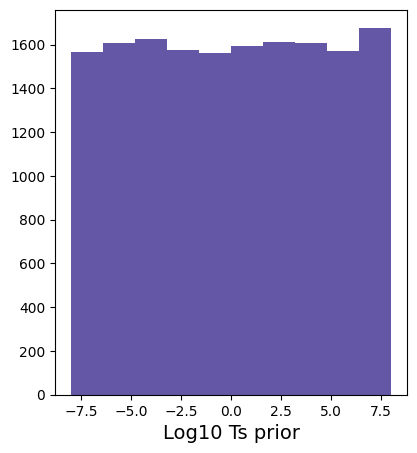

In [ ]:
# visualize the prior via sampling
nsamples = 1000
ts_sample = np.zeros((nsamples, npca_comps))
for i in range(nsamples):
  samp = prior.sample()
  ts_sample[i] = np.array(samp)

plt.clf()


ts_sample = ts_sample.flatten()
fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(121)
ax0.hist(ts_sample, color = '#6457A6')
ax0.set_xlabel('Log10 Ts prior', fontsize=14)
plt.show()

## Make a SBI-wrapper on the simulator object
This is necessary if you're using any sort of embedding network, because you'll need to join the embedding network together with the flow estimator network into one neural posterior estimator to rule them all.

In [ ]:
# Total number of indices
total_indices = ny * nx

# Generate all possible indices
all_indices = np.arange(total_indices)

# Shuffle the indices
np.random.shuffle(all_indices)

# Split into two different sets of indices
train_indices = all_indices[:n_train]
test_indices = all_indices[n_train:(n_train + n_test)]

In [ ]:
train_spectra = cube_rs[train_indices, :]
test_spectra = cube_rs[test_indices, :]
train_params = temp_rs__[train_indices, :]

In [ ]:
# Train spectra: Tb spectra here
train_spectra = torch.from_numpy(np.asarray(train_spectra, dtype = 'float32'))
test_spectra = torch.from_numpy(np.asarray(test_spectra, dtype = 'float32'))

# train params: Tspin here
train_params = torch.from_numpy(np.asarray(train_params, dtype = 'float32'))

test_ts_spectra = ts_cube_rs[test_indices, :]
test_tau_spectra = tau_cube_rs[test_indices, :]

In [ ]:
# Move to CPU or GPU
train_params = train_params.to(device)
train_spectra = train_spectra.to(device)

# test set
test_spectra = test_spectra.to(device)

## Instantiate the neural density estimator (NDE)
A NDE is the internal mechanism that associates thetas with xs. Again, the hidden features of the NDE are learned along with those of the embedding network.

Here we're using a masked autoregressive flow (MAF) for the NDE. For more information about MAFs, see the slides by Jason Poh: LINK.

We're using five hidden features for each unit of the MAF and two transforms, which are invertible neural density transforms.


In [ ]:
# I will leave this blank

## Set up the inference procedure
We will use the SNPE-C procedure, which is sequential neural posterior estimation with C option.

In [ ]:
inference = # I will leave this blank

## Run the inference procedure
First simulate 1000 data, parameter pairs. Then, train the inference object using this dataset. Finally, build the posterior.

This should take a minute or so.

In [ ]:
density_estimator = # I will leave this blank
posterior = # I will leave this blank

print('Finished Training...')

print('Sampling...')

 Neural network successfully converged after 420 epochs.Finished Training...
Sampling...


In [ ]:
# Save the density estimator and inference object
inference_path = checkpoint_path / 'ts_snpe_inference.pkl'
posterior_path = checkpoint_path / 'ts_snpe_posterior.pt'
density_path = checkpoint_path / 'ts_density_estimator.pt'

In [ ]:
# Save the inference object with pickle
with open(inference_path, "wb") as f:
    pickle.dump(inference, f)

<ipython-input-219-2bdfc48a8509>:5: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, f)


In [ ]:
# Save the inference, density estimator
torch.save(posterior, posterior_path)
torch.save(density_estimator, density_path)

In [ ]:
# Load the saved inference, and posterior
with open(inference_path, 'rb') as file:
    inference = pickle.load(file)

posterior = torch.load(posterior_path)
density = torch.load(density_path)

# Test the framework: 3 cases

3 examples: Draw from the posterior

Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_indices = [7, 33, 19]
ts_med_spectrum_log_arr = np.zeros((3, 256))
ts_pred_std_log_arr = np.zeros((3, 256))

for k, test_idx in enumerate(test_indices):
    test_spectrum = test_spectra[test_idx].unsqueeze(0)
    samples = posterior.blank.sample((10_000,)) # I will leave this blank
    print(f'{test_idx}: Finish sampling...')

    ts_pred_pca_spectra = samples.cpu().numpy()
    ts_pred_spectra_log = # I will leave this blank
    ts_med_spectrum_log = # I will leave this blank
    ts_pred_std_log = # I will leave this blank

    ts_med_spectrum_log_arr[k, :] = ts_med_spectrum_log
    ts_pred_std_log_arr[k, :] = ts_pred_std_log


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

7: Finish sampling...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

33: Finish sampling...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

19: Finish sampling...


The figure below shows the statistics of the generated samples. The red line shows the true value.

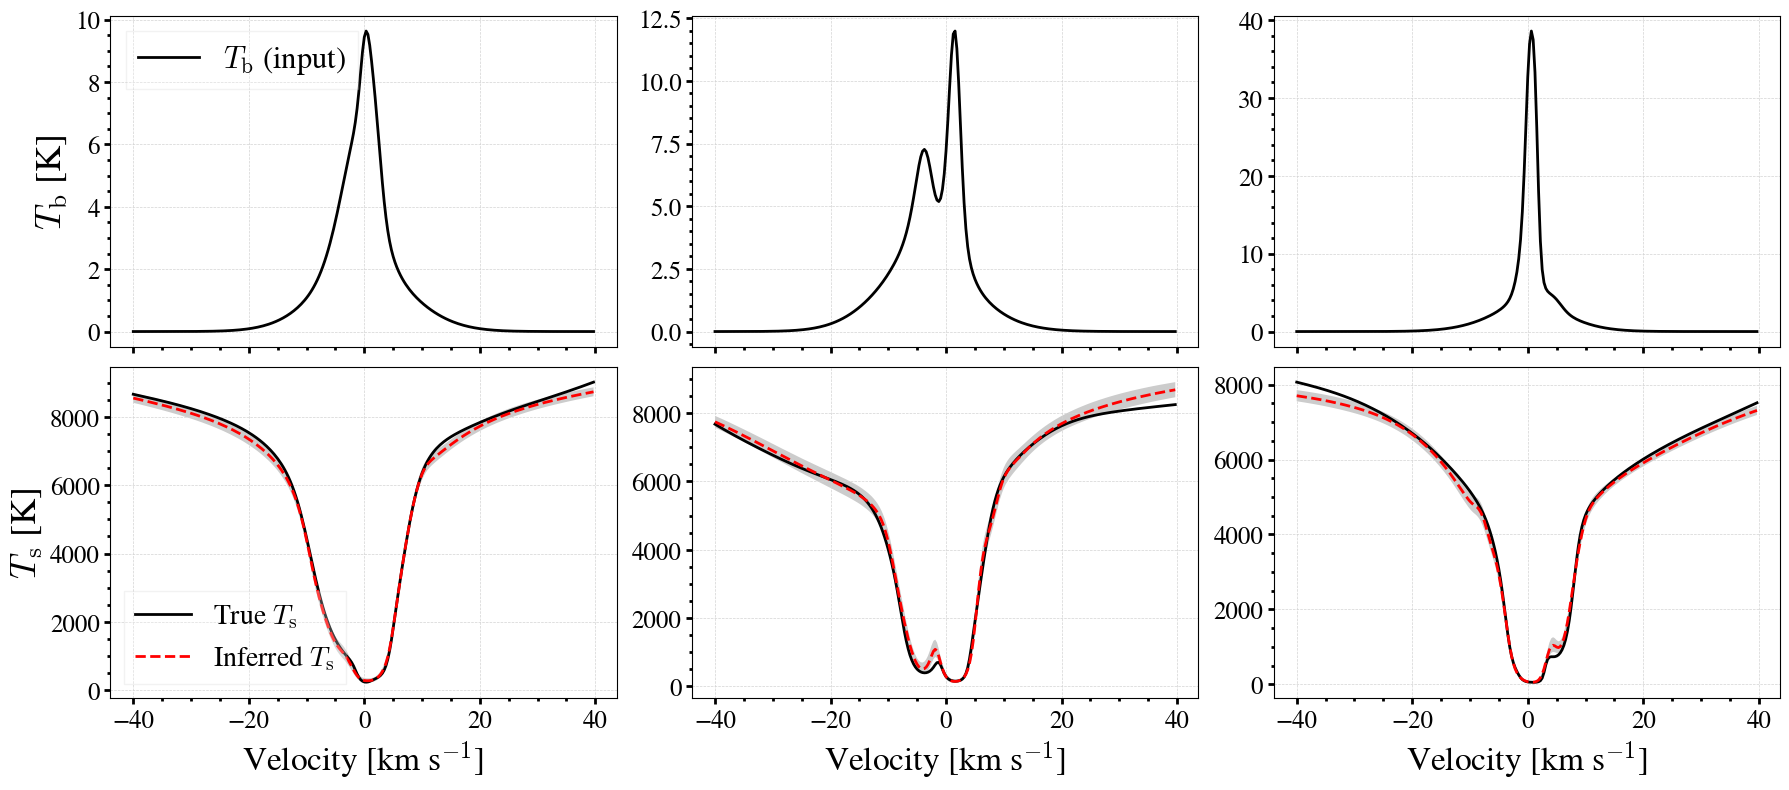

In [ ]:
#
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True)



kid = 0
test_idx = test_indices[kid]

ax1 = axs[0,0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='$T_\mathrm{b}$ (input)')

ax1.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=26)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=18, pad=4)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax1.legend(loc='upper left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=22)


#
ax4 = axs[1,0]
# I will leave this blank


ax4.set_xlabel('Velocity [km s$^{-1}$]', fontsize=24)
ax4.set_ylabel('$T_\mathrm{s}$ [K]', fontsize=26)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=18, pad=4)
ax4.tick_params(axis='y', labelsize=18)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax4.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=20)




####
kid = 1
test_idx = test_indices[kid]

ax1 = axs[0,1]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='$T_\mathrm{b}(v)$ (input)')

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=18, pad=4)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

#
ax4 = axs[1,1]
# I will leave this blank


ax4.set_xlabel('Velocity [km s$^{-1}$]', fontsize=24)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=18, pad=4)
ax4.tick_params(axis='y', labelsize=18)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




####
kid = 2
test_idx = test_indices[kid]

ax1 = axs[0,2]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='$T_\mathrm{b}(v)$ (input)')

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=18, pad=4)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax4 = axs[1,2]
# I will leave this blank


ax4.set_xlabel('Velocity [km s$^{-1}$]', fontsize=24)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=18, pad=4)
ax4.tick_params(axis='y', labelsize=18)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Test 1 case: Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 3

In [ ]:
test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
samples = posterior.blank.sample((256,))
print('Finish sampling...')

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()

ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log = # I will leave this blank

Plotting results...


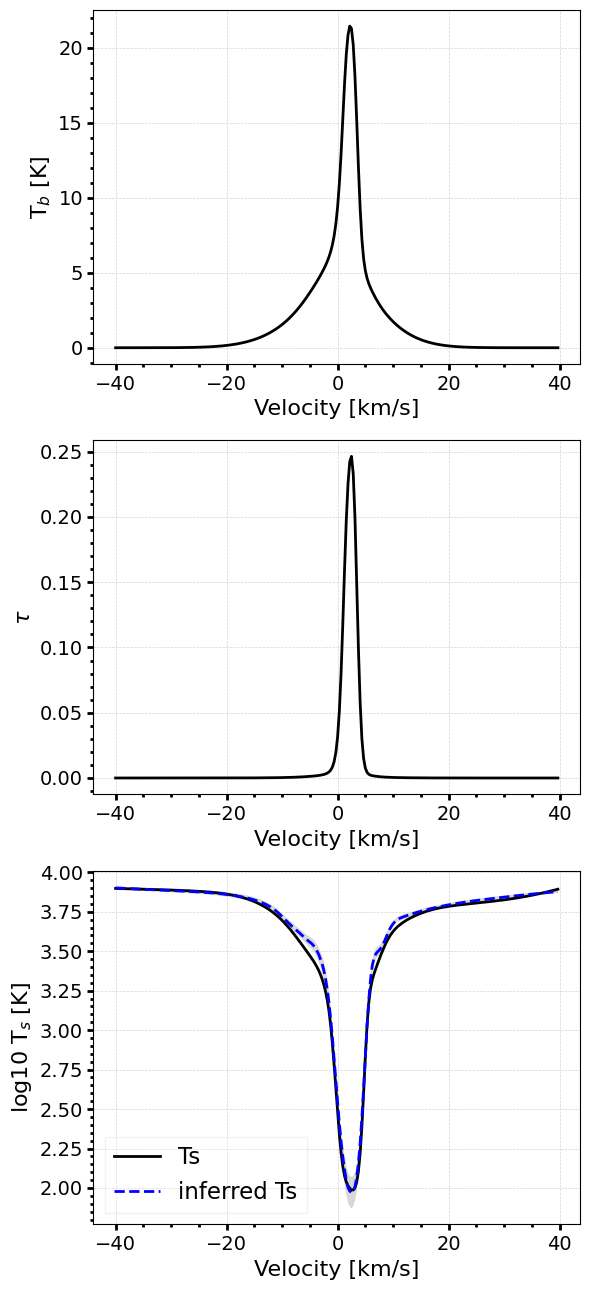

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


# Axis
ax3 = axs[2]
# I will leave this blank



# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('log10 T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig(saury_data_path / '.png', bbox_inches='tight')

# Show the plot
plt.show()

Plotting results...


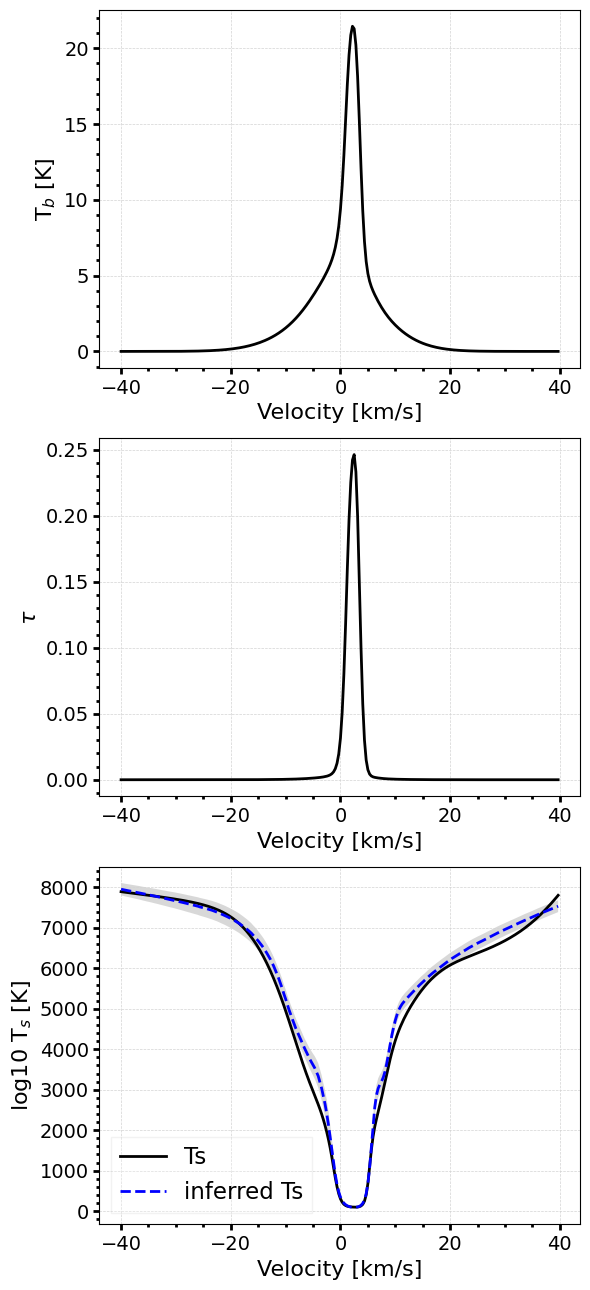

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('log10 T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig(saury_data_path / '.png', bbox_inches='tight')

# Show the plot
plt.show()

# Sampling with MCMC

In [ ]:
# Sampling with MCMC
mcmc_posterior = inference.blank() # I will leave this blank

# Test the model on the test set
test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
inferred_params = posterior.blank((1024,))

print('Finish sampling...')


ts_pred_pca_spectra_mcmc = inferred_params.cpu().numpy()
ts_pred_spectra_mcmc_log = # I will leave this blank
ts_med_spectrum_mcmc_log = # I will leave this blank
ts_pred_std_mcmc_log     = # I will leave this blank

/usr/local/lib/python3.10/dist-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Finish sampling...


Plotting results...


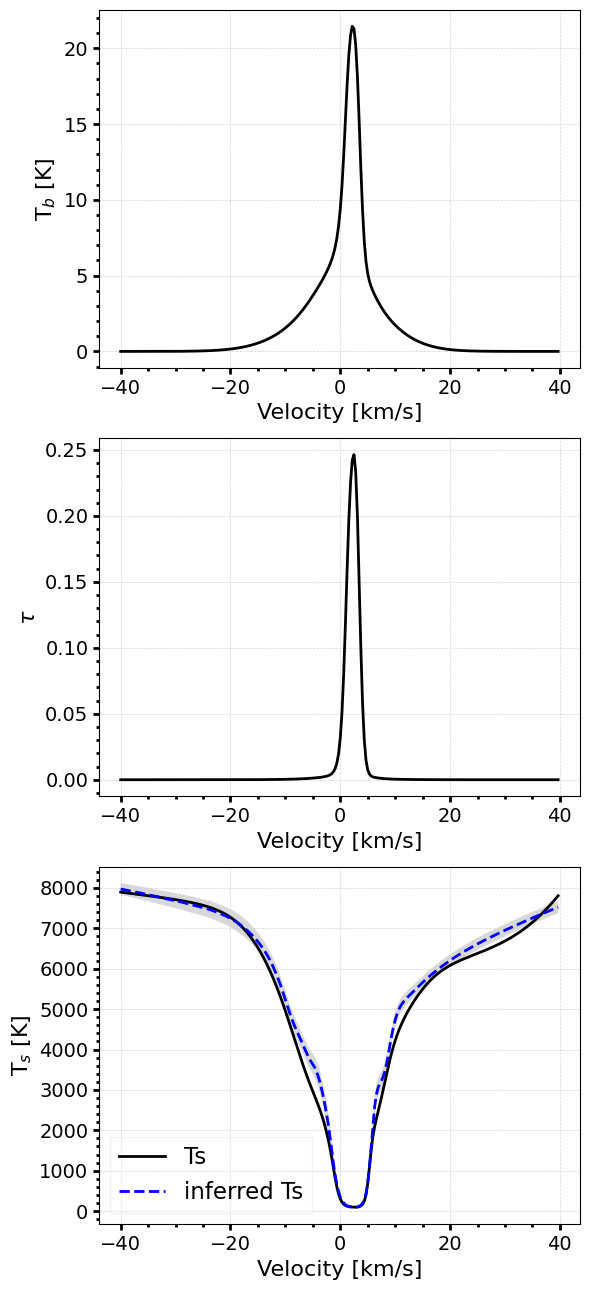

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 0

test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
samples = posterior.blank()((1024,)) # I will leave this blank
print('Finish sampling...')

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()
ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log     = # I will leave this blank

Plotting results...


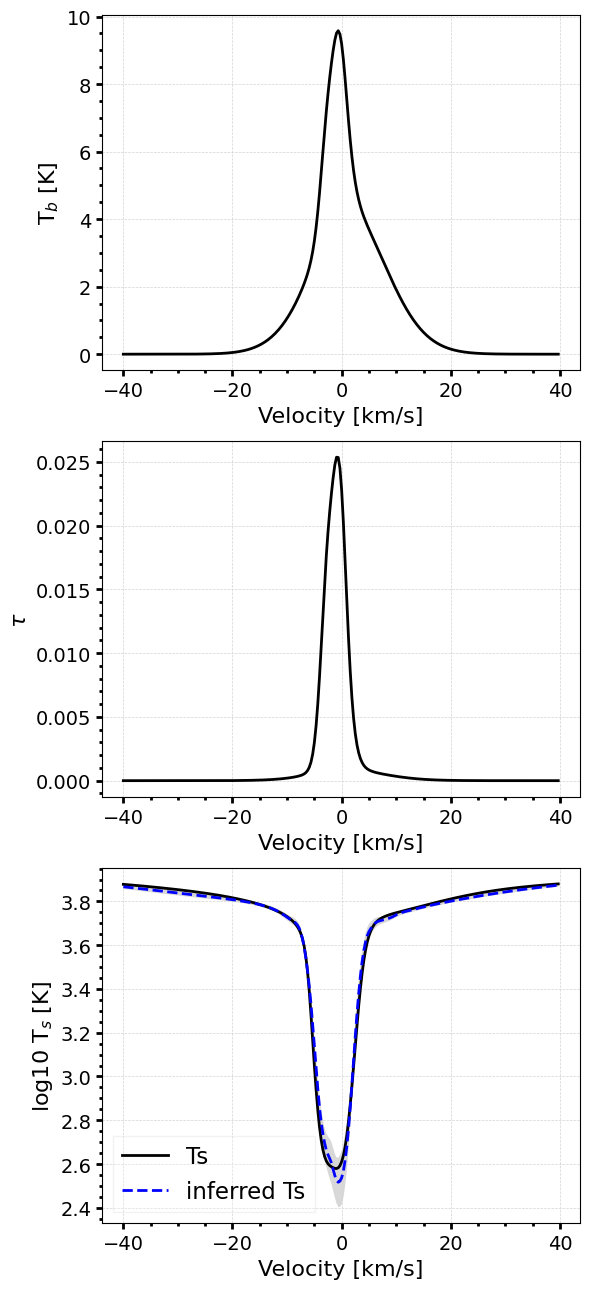

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax3 = axs[2]
# I will leave this blank

# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('log10 T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

Plotting results...


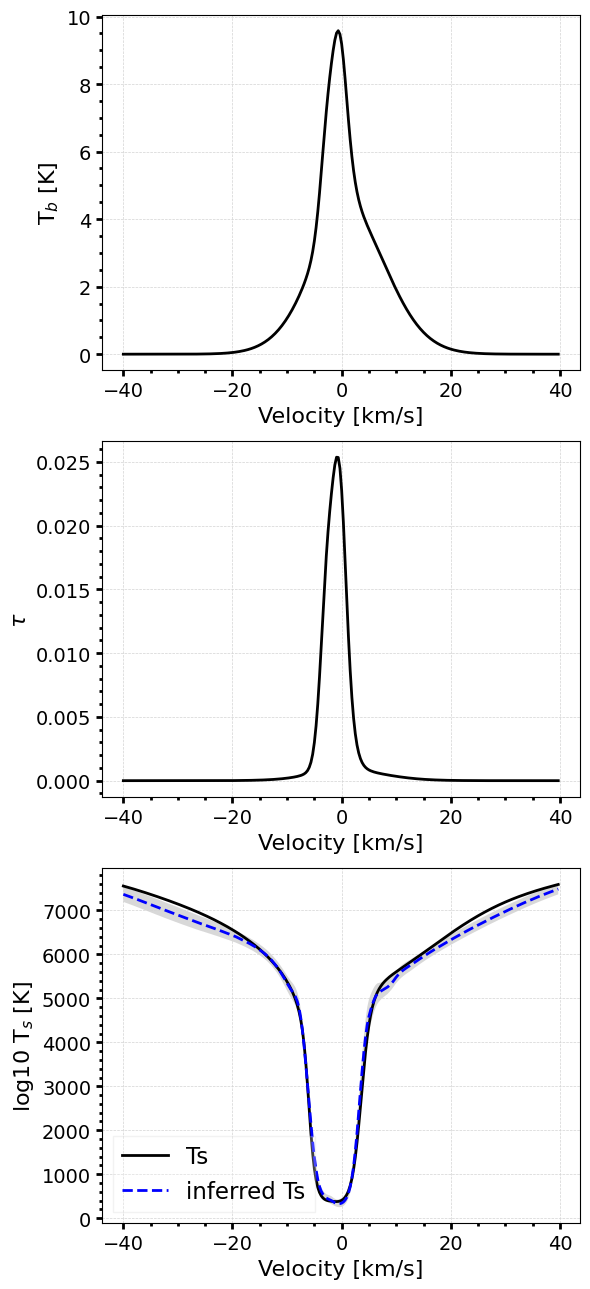

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('log10 T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Sampling with MCMC

In [ ]:
# Sampling with MCMC
mcmc_posterior = inference.blank() # I will leave this blank

# Test the model on the test set
test_spectrum = test_spectra[test_idx].unsqueeze(0)
inferred_params = posterior.blank()

print('Finish sampling...')


ts_pred_pca_spectra_mcmc = # I will leave this blank
ts_pred_spectra_mcmc_log = # I will leave this blank
ts_med_spectrum_mcmc_log = # I will leave this blank
ts_pred_std_mcmc_log     = # I will leave this blank

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Finish sampling...


Plotting results...


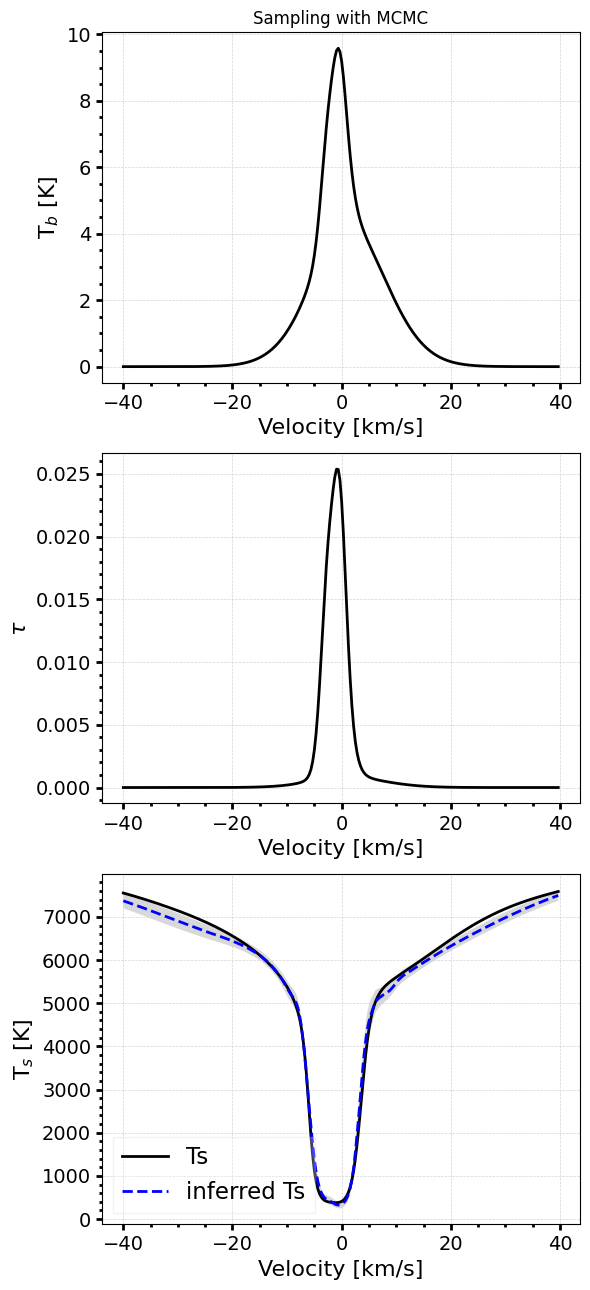

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_title('Sampling with MCMC')
ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax3 = axs[2]
# I will leave this blank


# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 2
test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
samples = posterior.blanck().sample((1024,)) # I will leave this blank
print('Finish sampling...')

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()

ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log = # I will leave this blank

Plotting results...


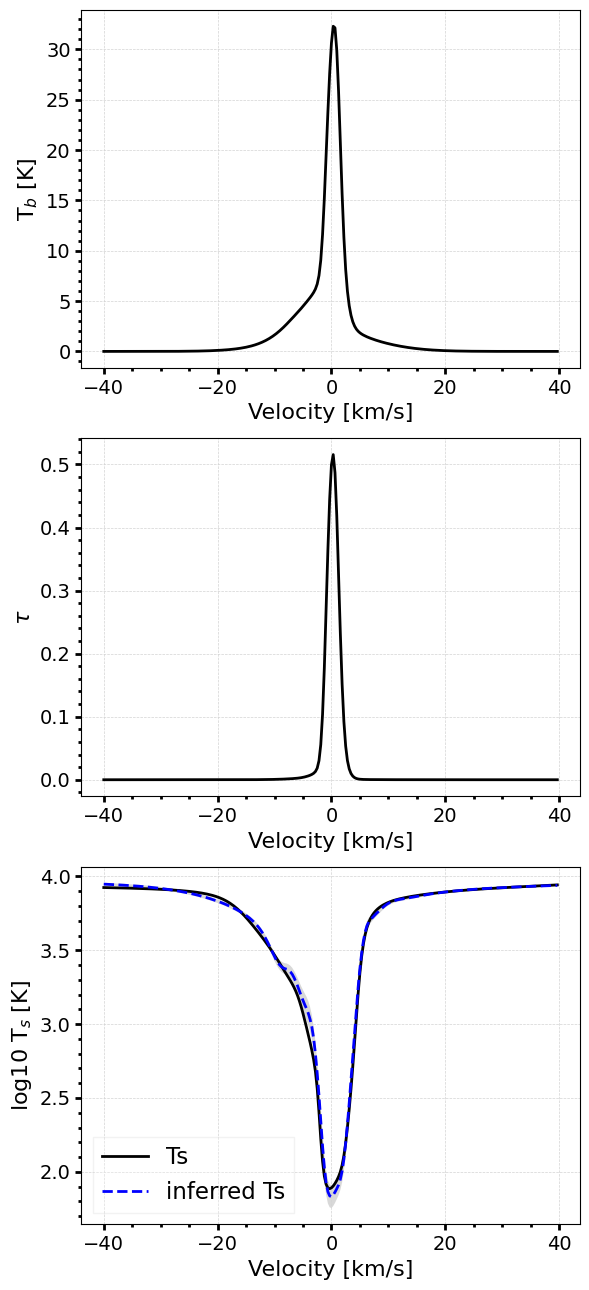

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank



# ax3.set_title('Training set')
ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('log10 T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

Plotting results...


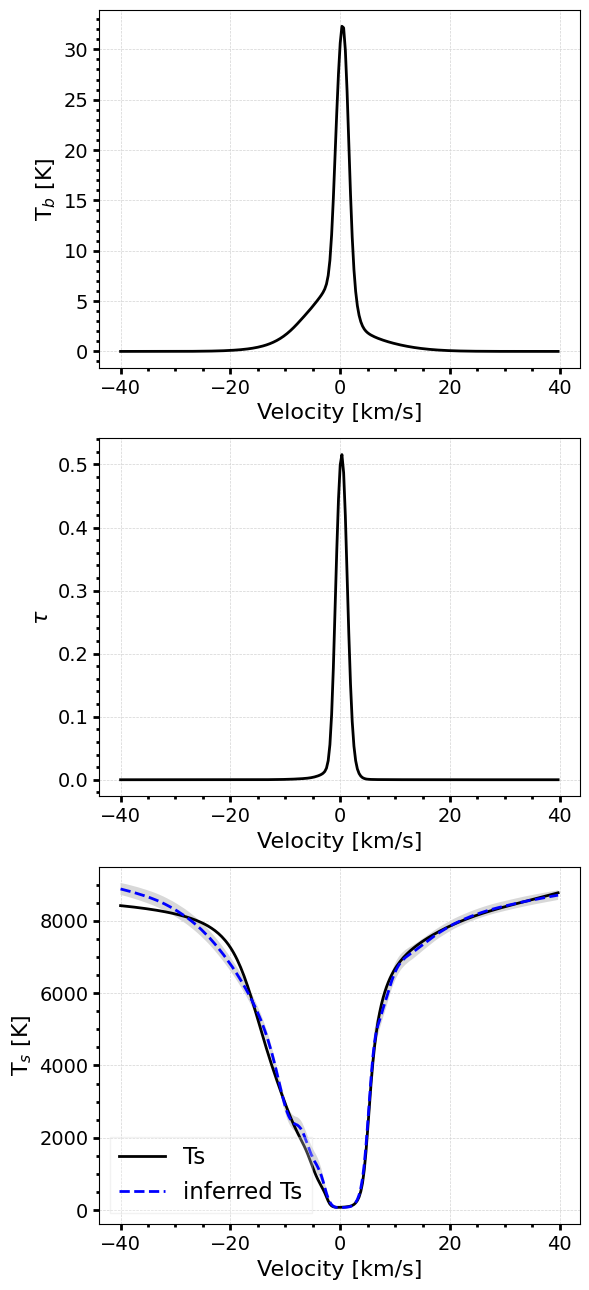

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Sampling with MCMC

In [ ]:
# Sampling with MCMC
mcmc_posterior = inference.blank() # I will leave this blank

# Test the model on the test set
test_spectrum = test_spectra[test_idx].unsqueeze(0)
inferred_params = posterior.blank()

print('Finish sampling...')

ts_pred_pca_spectra_mcmc = # I will leave this blank
ts_pred_spectra_mcmc_log = # I will leave this blank
ts_med_spectrum_mcmc_log = # I will leave this blank
ts_pred_std_mcmc_log = # I will leave this blank

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Finish sampling...


Plotting results...


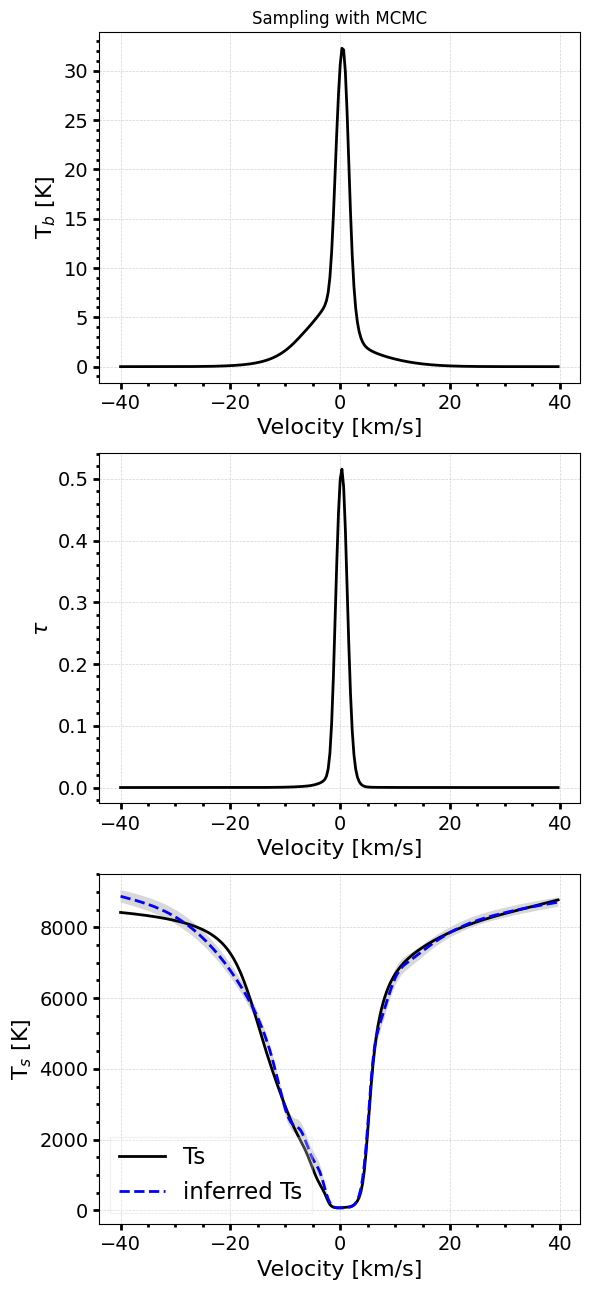

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_title('Sampling with MCMC')
ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


ax3.set_xlabel('Velocity [km/s]', fontsize=16)
ax3.set_ylabel('T$_s$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()